Profiling decorrelation and node perturbation

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from node_perturbation.node_perturbation import NPLinear
from node_perturbation.utils import np_train
from decorrelation.utils import decor_train
from decorrelation.decorrelation import Decorrelation, DecorLinear
import matplotlib.pyplot as plt
import argparse

import cProfile
import pstats
from torch.profiler import profile, record_function, ProfilerActivity

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

Testing the effect of decprrelating after larger intervals

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        torch.flatten # for input to linear layer
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [17]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, bias_lr=0.0, kappa=1e-2, epochs=20)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

intervals = np.arange(1, 20, 2)
L = torch.zeros(len(intervals))
for i, interval in enumerate(intervals):
    res = decor_train(args, model, lossfun, train_loader, device, interval=interval)
    L[i] = res[1][-1]

epoch 0  	time:0.000 s	bp loss: 4.936367	decorrelation loss: 6.581284
epoch 1  	time:0.564 s	bp loss: 4.407383	decorrelation loss: 2.376971
epoch 2  	time:0.571 s	bp loss: 3.798684	decorrelation loss: 0.515520
epoch 3  	time:0.570 s	bp loss: 3.451408	decorrelation loss: 0.262065
epoch 4  	time:0.567 s	bp loss: 3.213826	decorrelation loss: 0.173414
epoch 5  	time:0.575 s	bp loss: 3.010409	decorrelation loss: 0.132037
epoch 6  	time:0.559 s	bp loss: 2.837193	decorrelation loss: 0.109211
epoch 7  	time:0.555 s	bp loss: 2.689010	decorrelation loss: 0.097512
epoch 8  	time:0.570 s	bp loss: 2.537649	decorrelation loss: 0.088141
epoch 9  	time:0.560 s	bp loss: 2.407167	decorrelation loss: 0.084132
epoch 10 	time:0.564 s	bp loss: 2.289983	decorrelation loss: 0.079693
epoch 11 	time:0.564 s	bp loss: 2.182085	decorrelation loss: 0.076153
epoch 12 	time:0.564 s	bp loss: 2.072193	decorrelation loss: 0.074996
epoch 13 	time:0.566 s	bp loss: 1.975017	decorrelation loss: 0.074749
epoch 14 	time:0.571

Text(0, 0.5, 'loss')

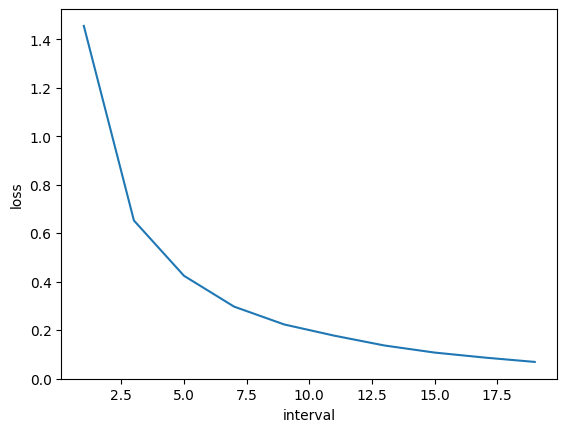

In [18]:
plt.plot(intervals, L)
plt.xlabel('interval')
plt.ylabel('loss')
# WHY DONT WE OBSERVE THE IMPROVEMENT? COMPARE WITH BP!

Profiling node perturbation

In [3]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, bias_lr=0.0, kappa=1e-2, epochs=3, full=True)
lossfun = torch.nn.CrossEntropyLoss().to(device)
sampler = torch.distributions.Distribution = torch.distributions.Normal(0.0, 1e-3)

# model = NPLinear(784, 10, sampler=sampler, device=device)
# model, L1, D, T = np_train(args, model, lossfun, train_loader, device)

model = nn.Sequential(Decorrelation(784, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa, full=args.full), NPLinear(784, 10, sampler=sampler, device=device))

cProfile.run('np_train(args, model, lossfun, train_loader, device)', 'restats')
p = pstats.Stats('restats')
p.sort_stats('cumulative').print_stats(10)
p.sort_stats('time').print_stats(10)


epoch 0  	time:0.000 s	bp loss: 5.125478	decorrelation loss: 6.575234
epoch 1  	time:0.611 s	bp loss: 5.028853	decorrelation loss: 2.408464
epoch 2  	time:0.603 s	bp loss: 4.923016	decorrelation loss: 0.571336
epoch 3  	time:0.618 s	bp loss: 4.878056	decorrelation loss: 0.326010
Sun Mar 10 10:16:36 2024    restats

         565799 function calls (560447 primitive calls) in 2.097 seconds

   Ordered by: cumulative time
   List reduced from 332 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.097    2.097 {built-in method builtins.exec}
        1    0.000    0.000    2.097    2.097 <string>:1(<module>)
        1    0.007    0.007    2.097    2.097 /Users/marcel.vangerven/Code/github/decorrelation/node_perturbation/utils.py:7(np_train)
       45    0.001    0.000    1.205    0.027 /Users/marcel.vangerven/Code/github/decorrelation/decorrelation/decorrelation.py:14(decor_update)
       45    1.182    0.02

Pytroch profiling. See https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html for more examples

In [4]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, bias_lr=0.0, kappa=1e-2, epochs=3, full=True)
lossfun = torch.nn.CrossEntropyLoss().to(device)
sampler = torch.distributions.Distribution = torch.distributions.Normal(0.0, 1e-3)

model = nn.Sequential(Decorrelation(784, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa, full=args.full), NPLinear(784, 10, sampler=sampler, device=device))

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_training"):
        np_train(args, model, lossfun, train_loader, device)

STAGE:2024-03-10 10:16:36 8347:7102419 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


epoch 0  	time:0.000 s	bp loss: 5.232002	decorrelation loss: 6.581224
epoch 1  	time:0.602 s	bp loss: 5.170646	decorrelation loss: 2.429324
epoch 2  	time:0.600 s	bp loss: 5.116081	decorrelation loss: 0.569070
epoch 3  	time:0.609 s	bp loss: 5.088414	decorrelation loss: 0.327403


STAGE:2024-03-10 10:16:38 8347:7102419 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-10 10:16:38 8347:7102419 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [5]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         model_training         2.55%      52.495ms       100.00%        2.059s        2.059s             1  
                                           aten::matmul         0.24%       4.855ms        61.50%        1.266s       5.628ms           225  
                                               aten::mm        61.46%        1.266s        61.46%        1.266s       5.625ms           225  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        17.60%     362.434ms        27.06%     557.259ms       8.707ms            64  
      

In [6]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                 Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------  
                                         model_training         2.55%      52.495ms       100.00%        2.059s        2.059s             1                                           []  
                                           aten::matmul         0.02%     343.000us        49.44%        1.018s      22.624ms            45                     [[784, 784], [784, 784]]  
                                               aten::mm        49